In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

In [2]:
import numpy as np
from neuron import h
from pybrep.pop_generation.bridson import Bridson_sampling_2d, Bridson_sampling_3d

h.load_file("../../test/set3005/Parameters.hoc")
h.MFxrange += 50
h.MFyrange += 50
h.GLdepth += 50

Nseg for APical is 5 and Basal is 3
	36 


/opt/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
def compute_mf_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    n_mf = int(
        (Transverse_range + (2 * Xinstantiate))
        * (Horizontal_range + (2 * Yinstantiate))
        * MFdensity
        * 1e-6
    )
    print("N MF = {}".format(n_mf))
    return (
        (Horizontal_range + (2 * Yinstantiate), Transverse_range + (2 * Xinstantiate)),
        n_mf,
    )


mf_box, n_mf = compute_mf_params(h)

spacing_mf = 20.5
mf_points = Bridson_sampling_2d(mf_box, spacing_mf, n_mf, True)

np.savez(
    "coords_20190613_1.npz",
    mf=mf_points
)

N MF = 3031


Iteration: 504, (final)Points Created: 3031, is_grid_empty:5880 (65.98586017282011%)


In [12]:
def compute_goc_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth + 50

    Volume = Transverse_range * Horizontal_range * Vertical_range

    d_goc = h.GoCdensity
    n_goc = int(d_goc * Volume * 1e-9)
    return ((Horizontal_range, Transverse_range, Vertical_range), n_goc)


goc_box, n_goc = compute_goc_params(h)
spacing_goc = 45.5 - 1  # 40 #(NH Barmack, V Yakhnitsa, 2008)

goc_points = Bridson_sampling_3d(goc_box, spacing_goc, n_goc, True)
goc_points = goc_points + np.random.normal(
    0, 1, size=(len(goc_points), 3)
)  # Gaussian noise


np.savez(
    "coords_20190613_1.npz",
    mf=mf_points,
    goc=goc_points
)
# _ = plt.hist(goc_points[:, 2], 50)

Iteration: 4193, (final)Points Created: 3313, is_grid_empty:18647 (84.91347905282332%)


In [ ]:
from sklearn.neighbors import KDTree

goc_tree = KDTree(goc_points)
d_goc_glo = 27 / 2 + (7.6) / 2 - 1

scale_factor = 0.29/0.75

def fgoc(x):
    y = x.copy()
    y[:, 1] = y[:, 1] / scale_factor
    nnsearch = goc_tree.query_radius(y, r=d_goc_glo, count_only=True)
    return nnsearch == 0


def compute_glo_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    d_grc = 1.9 * 1e6  # (Billings et al., 2014)
    d_glo = d_grc*0.3
#     d_glo = 6.6 * 1e5  # (Billings et al., 2014)
    n_glo = int(d_glo * Volume * 1e-9)
    print("N of Glomeruli = {}".format(n_glo))

    return ((Horizontal_range, int(Transverse_range*scale_factor+0.5) , Vertical_range), n_glo)


# Glomerulus (Rosettes)
globox, n_glo = compute_glo_params(h)

# (Billings et al., 2014) Since glomeruli is elipsoid shape, I recalculated based on the spatial occupancy of glomeruli and its density. Also, I subtract 1 cuz I will give Gaussian noise
spacing_glo = 8.5 - 1

glo_points = Bridson_sampling_3d(globox, spacing_glo, n_glo, True, ftests=[fgoc])

# Since glomerulus is stretched for Horizontal section, we will generate coordinates in small area at first, and then multiply it with 3. (Billings et al., 2014)
glo_points[:, 1] = glo_points[:, 1]/scale_factor


N of Glomeruli = 165656


In [ ]:
np.savez(
    "coords_20190613_1.npz",
    mf=mf_points,
    goc=goc_points,
    glo=glo_points
)


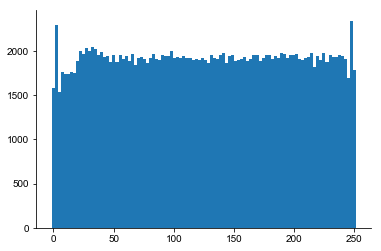

In [94]:
_ = plt.hist(glo_points[:, 2], 100)

In [ ]:
d_goc_grc = 27 / 2 + 7.2 / 2 - 1


def fgoc(x):
    nnsearch = goc_tree.query_radius(x, r=d_goc_grc, count_only=True).astype(bool)
    return nnsearch == 0


glo_tree = KDTree(glo_points)
d_glo_grc = 6.6 / 1.5 + 6 / 2 - 1


def fglo(x):
    nnsearch = glo_tree.query_radius(x, r=d_glo_grc, count_only=True).astype(bool)
    return nnsearch == 0


def compute_grc_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    d_grc = 1.9 * 1e6  # (Billings et al., 2014)
    n_grc = int(d_grc * Volume * 1e-9)

    print("N of GrC = {}".format(n_grc))

    return ((Horizontal_range, Transverse_range, Vertical_range), n_grc)


# (Billings et al., 2014) I subtract 1 because I will give Gaussian noise
spacing_grc = 6 - 1

grcbox, n_grc = compute_grc_params(h)
grc_points = Bridson_sampling_3d(grcbox, spacing_grc, n_grc, True, ftests=[fgoc, fglo])

In [ ]:
np.savez(
    "coords_20190604_1.npz",
    mf=mf_points,
    goc=goc_points,
    glo=glo_points,
    grc_nop=grc_points,
)